In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    CutoffSplitter,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    # functions
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
    mean_squared_scaled_error,
    # classes
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
    MeanSquaredError,
    MeanSquaredScaledError,
)

from dsf_utils.preprocessing import process_raw_data, single_region_ts
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

# Data

In [31]:
# California time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
ts = single_region_ts(main_df, region="California")

# The rules of the game

We will assess the performance of the forecasting algorithms using a fixed length training window test performance of a 3-week ahead forecast in the following 8 cutt-off points:
* off-season: 2018-07-01, 2019-07-01
* flu-season start: 2018-10-01, 2019-09-01
* flus-season peak: 2018-12-15, 2019-11-15
* flu-season end: 2019-03-01, 2019-05-01

We'll evaluate forecast based on **RMSSE** and use the Seasonal Naive forecaster as a baseline

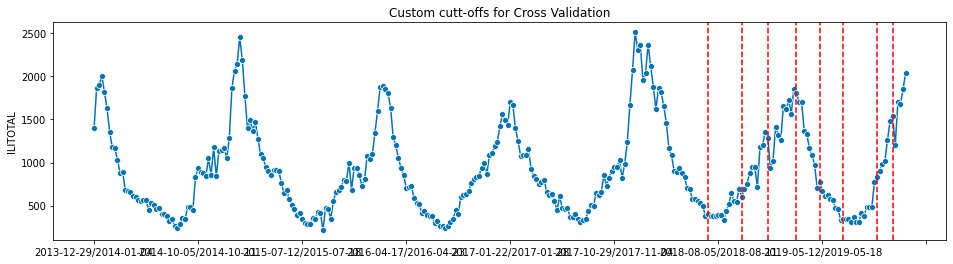

In [29]:
custom_cutoffs = np.array([
    len(ts[ts.index <= date]) 
    for date in 
    [
        # off-season
        "2018-07-01", 
        "2019-07-01", 
        # season start
        "2018-10-01", 
        "2019-10-01", 
        # season peak
        "2018-12-15", 
        "2019-11-15", 
        # season end
        "2019-03-01", 
        "2019-05-01"
    ]
])

# create the CV object
cv = CutoffSplitter(
    # custom cuttoffs
    cutoffs=custom_cutoffs, 
    # 3 step ahead forecast
    fh=np.arange(3)+1,
    # 5 years of training data
    window_length=5*52,
)

rmsse = MeanSquaredScaledError()

plot_series(ts)
for cutoff in custom_cutoffs: 
    plt.axvline(cutoff, color="red", linestyle="--")
plt.title("Custom cutt-offs for Cross Validation")
plt.show()

# Seasonal Naive Benchmark

In [33]:
# insert code

# Exponential Smoothing

In [34]:
# insert code

In [35]:
# STL transform